# Getting Started with Modeling Integrase and Excisionase Activity
The goal of this notebook is to model integrase and excisionase activity in TX-TL using mechanistic chemical reaction network models.
Refer to the "Modeling Integrase Activity.ipynb" and "Modeling Integrase Excisionase Activity.ipynb" for detailed information on the individual models.

## Chemical Reaction Network (CRN) models:

To create the CRN models, run `pip install biocrnpyler` in your terminal for the notebook environment. This installs the [BioCRNpyler](https://github.com/BuildACell/BioCRNPyler) package to build mechanistic chemical reaction networks. 

In [1]:
from biocrnpyler import *

Integrase flipping CRN:

Integrase flipping CRN:

$attB + 2 I \rightleftharpoons attB:I_2$

$attP + 2 I \rightleftharpoons attP:I_2$

$attB:I_2 + attP:I_2 \xrightarrow{k_{int}} attL:I_2 + attR:I_2$

$attL:I_2 + attR:I_2 \rightleftharpoons A + 4I$

$ A \rightarrow Y + A$

where $I$ is the integrase, $A$ is activated plasmid (integrase flipped) and $Y$ is the reporter protein concentration.

We can further simplify the above CRN to represent the measurements that we have for integrase and flipped plasmid (CFP and YFP respectively).

Let R = unactivated reporter plasmid = attB--attP plasmid. So we can write:

$ \varnothing \rightarrow I $

$4 I + R \rightleftharpoons C$

$C \rightarrow C_A$

$ C_A \rightleftharpoons A + 4I$

$ A \rightarrow Y + A$

### Create IntegraseSite component and IntegraseFlipper mechanism to model integrase activity

In [2]:
from itertools import chain
class IntegraseSite(Component):
    def __init__(self, integrase: Species, 
                 curr_dna: Species, reversed_dna: Species, 
                 name: str=None, cooperativity: int=1, parameter_dict = None,
                 mechanism = None, **keywords):
        if name is None:
            name = integrase.name
        self.name = name
        self.integrase = integrase
        self.curr_dna = curr_dna
        self.reversed_dna = reversed_dna
        self.complex_species = None
        self.flipped_complex = None
        self.species = None
        self.cooperativity = cooperativity
        self.parameter_dict = parameter_dict
        mechanisms = {mechanism.mechanism_type:mechanism}
        Component.__init__(self=self, name=name, mechanisms=mechanisms, **keywords)
        
    def get_species(self) -> List[Species]:
        return self.species

    def update_species(self) -> List[Species]:
        integrase_flipper = self.get_mechanism('integrase-flipper')
        self.species = integrase_flipper.update_species(integrase = self.integrase, 
                                                        curr_dna = self.curr_dna, 
                                                        reversed_dna = self.reversed_dna, 
                                                        cooperativity = self.cooperativity)
        return self.species

    def update_reactions(self) -> List[Reaction]:
        integrase_flipper = self.get_mechanism('integrase-flipper')
        return integrase_flipper.update_reactions(integrase = self.integrase, curr_dna = self.curr_dna, 
                                                  reversed_dna = self.reversed_dna, cooperativity = self.cooperativity,
                                                  complex_species = self.complex_species, 
                                                  flipped_complex = self.flipped_complex, 
                                                  component = self, 
                                                  part_id = None, parameter_dict = self.parameter_dict)


class IntegraseFlipper(Mechanism):
    """Mechanism for the simple integrase flipping. 
    Integrase binds to attP-attB site, forms a complex,
    the complex flips the site to attL-attR, then integrase unbinds.
    """
    def __init__(self, name: str="integrase-flipper", mechanism_type: str="integrase-flipper", **keywords):
        """Initializes a IntegraseFlipper instance.
        :param name: name of the Mechanism, default: integrase-flipper
        :param mechanism_type: type of the Mechanism, default: integrase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)

    def update_species(self, integrase, curr_dna, reversed_dna, cooperativity):
        list_of_species = [cooperativity*[integrase], [curr_dna]]
        # attP_attB_4I
        complex_species = Complex(species = list_of_species)
        self.complex_species = complex_species
        # attL_attR_4I
        list_of_species = [cooperativity*[integrase], [reversed_dna]]
        flipped_complex = Complex(species = list_of_species)
        self.flipped_complex = flipped_complex
        return [integrase, curr_dna, reversed_dna, 
                complex_species, flipped_complex]

    def update_reactions(self, integrase, curr_dna, reversed_dna, cooperativity,
                         complex_species, flipped_complex, component = None, 
                         part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_i = component.get_parameter("a_i", part_id = part_id, mechanism = self)
            d_i = component.get_parameter("d_i", part_id = part_id, mechanism = self)
            k_int = component.get_parameter("k_int", part_id = part_id, mechanism = self)
            a_r = component.get_parameter("a_r", part_id = part_id, mechanism = self)
            d_r = component.get_parameter("d_r", part_id = part_id, mechanism = self)
        else:
            a_i = parameter_dict['a_i']
            d_i = parameter_dict['d_i']
            k_int = parameter_dict['k_int']
            a_r = parameter_dict['a_r']
            d_r = parameter_dict['d_r']
        
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex   
        list_of_species = [cooperativity*[integrase], [curr_dna]]
        integrase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species for item in sublist],
                                                              [complex_species],
                                                              k_forward = a_i, k_reverse = d_i)
        flipping_reaction = Reaction.from_massaction([complex_species], [flipped_complex], k_forward = k_int)
        
        list_of_species = [cooperativity*[integrase], [reversed_dna]]
        integrase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species for item in sublist],
                                                                k_forward = a_r, k_reverse = d_r)
        reactions = [integrase_binding_reaction, flipping_reaction, integrase_unbinding_reaction]
        return reactions

## Model TX-TL context using the TxTlMixture class:

In [3]:
class TxTlMixture(Mixture):
    def __init__(self, name="", rnap="RNAP", ribosome="Ribo", rnaase="RNAase", **kwargs):
        Mixture.__init__(self, name=name, **kwargs)

        # Create Components for TxTl machinery
        self.rnap = Protein(rnap)
        self.ribosome = Protein(ribosome)
        self.rnaase = Protein(rnaase)
        default_components = [
            self.rnap, self.ribosome, self.rnaase
        ]
        self.add_components(default_components)

        #Create TxTl Mechansisms
        mech_tx = Transcription_MM(rnap = self.rnap.get_species())
        mech_tl = Translation_MM(ribosome = self.ribosome.get_species())
        mech_rna_deg = Degredation_mRNA_MM(nuclease=self.rnaase.get_species())
        mech_cat = MichaelisMenten()
        mech_bind = One_Step_Binding()

       #Create Global Dilution Mechanisms
        dilution_mechanism = Dilution(filter_dict = {"rna":True, "machinery":False}, 
                                      default_on = False)
        default_mechanisms = {
            mech_tx.mechanism_type: mech_tx,
            mech_tl.mechanism_type: mech_tl,
            mech_cat.mechanism_type: mech_cat,
            mech_bind.mechanism_type:mech_bind,
            "dilution":mech_rna_deg,
        }

        self.add_mechanisms(default_mechanisms)

## Define parameters

In [22]:
# # Good parameter set (matching data taken in May 2022)
# parameter_dict = {'k_bpi': 100.0, # Binding of RNAP with integrase expressing promoter
#  'k_upi': 1.0, # Unbinding of RNAP with integrase expression promoter
#  'k_txi': 0.25, # Transcription of integrase expressing mRNA
#  'k_bri': 100.0, # Binding of ribosome with integrase mRNA
#  'k_uri': 1.0, # Unbinding of ribosome with integrase mRNA
#  'k_tli': 0.013, # Translation rate of integrase expression
#  'a_i': 10, # Binding of integrase to attP-attB
#  'd_i': 1.0, # Unbinding of integrase to attP-attB
#  'k_int': 0.10, # Integrase flip rate
#  'a_r': 0.033, # Unbinding rate of integrase from attL_attR-integrase bound complex
#  'd_r': 0.5, # Binding rate of integrase to attL_attR site 
#  'k_bp': 80.0, # Binding rate of RNAP to the reporter promoter
#  'k_up': 2.0, # Unbinding rate of RNAP from reporter promoter
#  'k_tx': 0.4, # Transcription rate of the reporter-mRNA
#  'k_br': 80.0, # Binding rate of ribosome to reporter-mRNA
#  'k_ur': 2.0, # Unbinding rate of ribosome from reporter-mRNA
#  'k_tl': 0.05, # Translation rate of reporter
#  'd_bTi': 20.0, # Binding rate of endonuclease to intergrase-mRNA
#  'd_uTi': 2.0, # Unbinding rate of endonuclease from integrase-mRNA
#  'd_Ti': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA
#  'd_bRTi': 20.0, # Binding rate of endonuclease to integrase-mRNA-ribosome complex
#  'd_uRTi': 2.0, # Unbinding rate of endonuclease to integrase-mRNA-ribosome complex
#  'd_RTi': 0.005, # Degradation rate of endonuclease-bound-integrase-mRNA-ribosome complex
#  'd_bT': 10.0, # Binding rate of endonuclease to reporter-mRNA
#  'd_uT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA
#  'd_T': 0.001, # Degradation rate of endonuclease-bound-reporter-mRNA
#  'd_bRT': 10.0, # Binding rate of endonuclease to reporter-mRNA-ribosome complex
#  'd_uRT': 2.0, # Unbinding rate of endonuclease from reporter-mRNA-ribosome complex
#  'd_RT': 0.005 # Degradation rate of endonuclease-bound-reporter-mRNA-ribosome complex
#                  }
parameters_dict = {("transcription_mm", "P_int", "kb"):100, 
                   ("transcription_mm", "P_int", "ku"):1,
                   ("transcription_mm", "P_int", "ktx"):0.25,
                   ("translation_mm", "RBS1", "kb"):100, 
                   ("translation_mm", "RBS1", "ku"):1,
                   ("translation_mm", "RBS1", "ktl"):0.013,
                   ("translation_mm", "RBS2", "kb"):80, 
                   ("translation_mm", "RBS2", "ku"):2,
                   ("translation_mm", "RBS2", "ktl"):0.05,
                   ("transcription_mm", "P_A", "kb"):80, 
                   ("transcription_mm", "P_A", "ku"):2,
                   ("transcription_mm", "P_A", "ktx"):0.4,
                   ("rna_degredation_mm", "rna_T_int", "kb"):20,
                   ("rna_degredation_mm", "rna_T_int", "ku"):2,
                   ("rna_degredation_mm", "rna_T_A", "kb"):10,
                   ("rna_degredation_mm", "rna_T_A", "ku"):2,
                   ("rna_degredation_mm", "rna_T_int", "kdeg"):0.005,
                   ("rna_degredation_mm", "rna_T_A", "kdeg"):0.001,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kdeg"): 0.005,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kb"): 10,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kdeg"): 0.005
                   }

# Measures E.coli extract endogenous mRNA degradation:
# https://jbioleng.biomedcentral.com/track/pdf/10.1186/1754-1611-4-9.pdf

In [23]:
# Integrase binding to DNA
a_i = ParameterEntry("a_i", 10)
# Integrase unbinding DNA
d_i = ParameterEntry("d_i", 1)

# Integrase flipping rate
k_int = ParameterEntry("k_int", 0.1)

# Integrase-attL_attR complex unbinding to form attL_attR and Integrase
a_r = ParameterEntry("a_r", 0.033)
# Binding of attL_attR and I to form Integrase-attL_attR complex 
d_r = ParameterEntry("d_r", 0.5)

parameters_integrase = {'a_i':a_i, 'd_i':d_i, 'k_int':k_int, 'a_r':a_r, 'd_r':d_r}

G_int = DNAassembly("G_int", promoter = "P_int", rbs = "RBS1", transcript = "T_int", protein = "Int")
G = DNAassembly("attL_attR", promoter = "P_A", rbs = "RBS2", transcript = "T_A", protein = "Y")
U = Species("attP_attB", material_type = "dna")
I0_mech = IntegraseFlipper()
I0 = IntegraseSite(integrase = G_int.protein, curr_dna = U, reversed_dna = G.dna,  
                   cooperativity = 2, parameter_dict = parameters_integrase,
                   mechanism = I0_mech)
M = TxTlMixture("Gene_Expr_Mix", components = [G_int, I0, G], 
                 parameters = parameters_dict)
CRN = M.compile_crn()
CRN.add_species(U)
CRN.write_sbml_file("integrase_txtl_resources.xml")

/home/codespace/.python/current/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


True

In [24]:
CRN

Species = dna_G_int, protein_RNAP, rna_T_int, complex_dna_G_int_protein_RNAP_, protein_Ribo, protein_Int, complex_protein_Ribo_rna_T_int_, dna_attP_attB, dna_attL_attR, complex_dna_attP_attB_protein_Int_2x_, complex_dna_attL_attR_protein_Int_2x_, rna_T_A, complex_dna_attL_attR_protein_RNAP_, protein_Y, complex_protein_Ribo_rna_T_A_, protein_RNAase, complex_protein_RNAase_rna_T_int_, complex_complex_protein_Ribo_rna_T_int__protein_RNAase_, complex_protein_RNAase_rna_T_A_, complex_complex_protein_Ribo_rna_T_A__protein_RNAase_
Reactions = [
	dna[G_int]+protein[RNAP] <--> complex[dna[G_int]:protein[RNAP]]
	complex[dna[G_int]:protein[RNAP]] --> dna[G_int]+rna[T_int]+protein[RNAP]
	rna[T_int]+protein[Ribo] <--> complex[protein[Ribo]:rna[T_int]]
	complex[protein[Ribo]:rna[T_int]] --> rna[T_int]+protein[Int]+protein[Ribo]
	2protein[Int]+dna[attP_attB] <--> complex[dna[attP_attB]:2x_protein[Int]]
	complex[dna[attP_attB]:2x_protein[Int]] --> complex[dna[attL_attR]:2x_protein[Int]]
	complex[dna[a

In [25]:
print(CRN.species)

[dna_G_int, protein_RNAP, rna_T_int, complex_dna_G_int_protein_RNAP_, protein_Ribo, protein_Int, complex_protein_Ribo_rna_T_int_, dna_attP_attB, dna_attL_attR, complex_dna_attP_attB_protein_Int_2x_, complex_dna_attL_attR_protein_Int_2x_, rna_T_A, complex_dna_attL_attR_protein_RNAP_, protein_Y, complex_protein_Ribo_rna_T_A_, protein_RNAase, complex_protein_RNAase_rna_T_int_, complex_complex_protein_Ribo_rna_T_int__protein_RNAase_, complex_protein_RNAase_rna_T_A_, complex_complex_protein_Ribo_rna_T_A__protein_RNAase_]


## Simulate the SBML model of integrase flipping in TX-TL context with bioscrape

To simulate the model, install bioscrape by running `pip install bioscrape` in your terminal. [Bioscrape](https://github.com/biocircuits/bioscrape/) is a fast Cython-based simulator for SBML models.

In [26]:
from bioscrape.types import Model 
from bioscrape.simulator import DeterministicSimulator, ModelCSimInterface, py_simulate_model
import numpy as np
m = Model(sbml_filename = 'integrase_txtl_resources.xml')
# Set resource levels
RNAP = 200
Ribo = 400
RNAase = 30
m.set_species({"protein_RNAP": RNAP, "protein_Ribo": Ribo, "protein_RNAase":RNAase})

In [27]:
# Simulate 
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0,0.25,0.5,0.75,1.]
num_integrase_conditions = len(int_levels)
rep_levels = [0,0.25,0.5,0.75,1.]
num_reporter_conditions = len(rep_levels)
for int_nm in int_levels:
    for rep_nm in rep_levels:
        m.set_species({"dna_G_int": int_nm, "dna_attP_attB": rep_nm})
        simulation_result = py_simulate_model(Model = m, timepoints = timepoints)
        simdata[(int_nm,rep_nm,'cfp')] = simulation_result['protein_Int']
        simdata[(int_nm,rep_nm,'yfp')] = simulation_result['protein_Y']

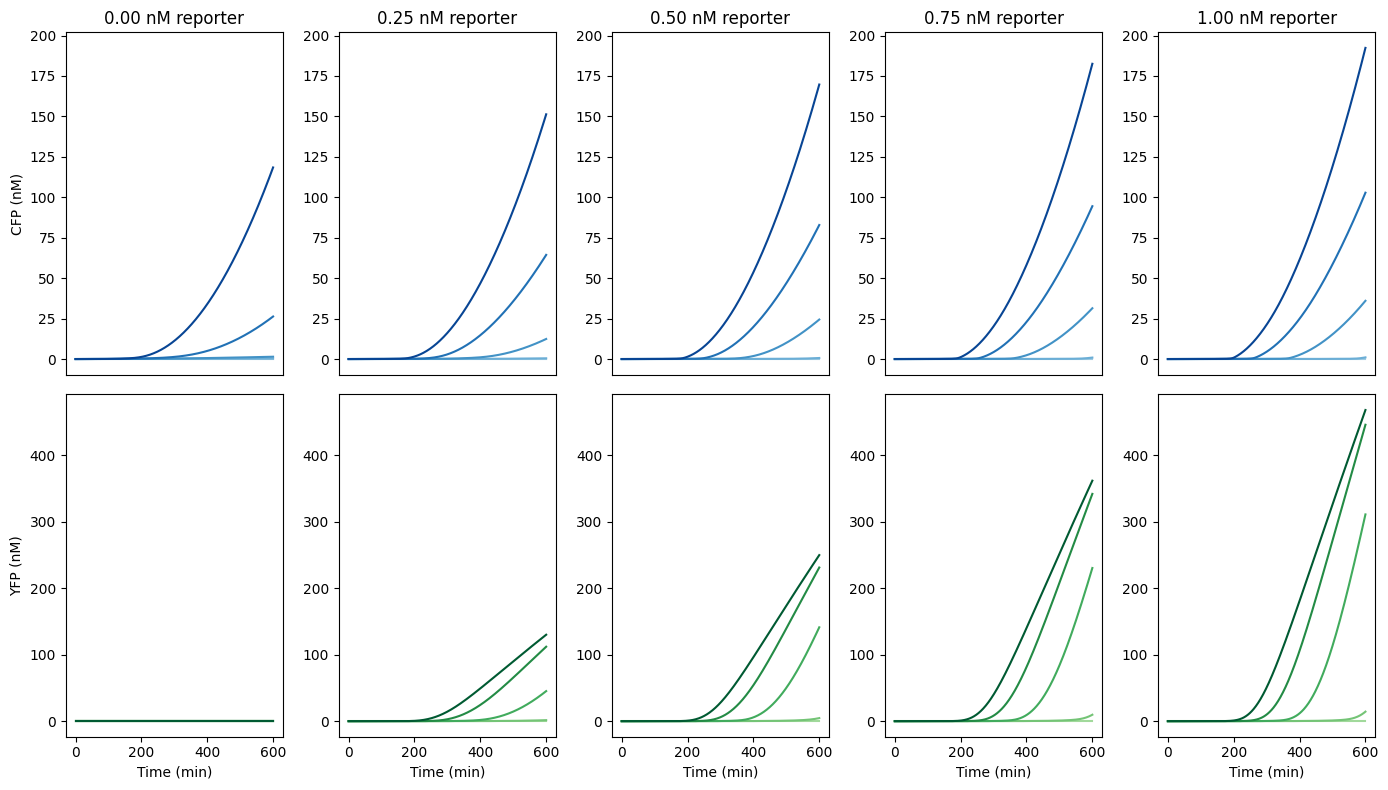

In [31]:
### Plot the results
import matplotlib.pyplot as plt
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']

figsize = (14,8)

fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):

    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)

    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)

    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
    axc.set_xticks([])

    index += 1
    
fig.tight_layout()

# Excisionase model with BioCRNpyler


Similar to the integrase model, we can write a chemical reaction network for the excisionase activity,

We have the activated plasmid A which has the attL and attR sites as a result of integrase activity. The excisionase can bind to these sites on the plasmid and convert these to the attP and attB sites, resulting in the flipping of the promoter back so that it is unactivated (that is, R). So we can write:


$ \varnothing \rightarrow E $

$n_E\cdot E + C_I \rightleftharpoons C_R$

$n_E\cdot E + C_A \rightleftharpoons C_E$

$C_E \rightarrow C_R$

$C_R \rightleftharpoons R + n_E \cdot E + n_I \cdot I$

and 

$I + E \rightleftharpoons C_{IE}$

$n_{IE} C_{IE} + A \rightleftharpoons C_{E}$

$n_{IE}C_{IE} + R\rightleftharpoons C_R$


We create the ExcisionaseSite component and two different mechanisms for excision: a detailed mechanism and a simpler version of it:

In [32]:
from itertools import chain
class ExcisionaseSite(Component):
    def __init__(self, excisionase: Species, integrase_site: Component,
                 curr_dna: Species, reversed_dna: Species,
                 name: str=None, cooperativity: int=1, parameter_dict = None,
                 mechanism = None, **keywords):

        if name is None:
            name = excisionase.name
        self.name = name
        self.excisionase = excisionase # E
        self.curr_dna = curr_dna # A 
        self.reversed_dna = reversed_dna # R
        integrase_site.update_species()
        self.integrase_site = integrase_site
        self.complex_species = None
        self.flipped_complex = None
        self.integrase_excisionase_complex = None
        self.species = None
        self.cooperativity = cooperativity
        self.parameter_dict = parameter_dict
        mechanisms = {mechanism.mechanism_type:mechanism}
        self.mechanism_type = mechanism.mechanism_type
        Component.__init__(self=self, name=name, mechanisms=mechanisms, **keywords)
        
    def get_species(self) -> List[Species]:
        return self.species

    def update_species(self) -> List[Species]:
        excisionase_flipper = self.get_mechanism(self.mechanism_type)
        self.species = excisionase_flipper.update_species(excisionase = self.excisionase, 
                                                          curr_dna = self.curr_dna, 
                                                          reversed_dna = self.reversed_dna, 
                                                          cooperativity = self.cooperativity,
                                                          integrase_site = self.integrase_site)
        return self.species
        

    def update_reactions(self) -> List[Reaction]:
        xis_flipper = self.get_mechanism(self.mechanism_type)
        return xis_flipper.update_reactions(excisionase = self.excisionase, 
                                            curr_dna = self.curr_dna, 
                                            reversed_dna = self.reversed_dna, 
                                            cooperativity = self.cooperativity,
                                            integrase_site = self.integrase_site, 
                                            complex_species = self.complex_species,
                                            flipped_complex = self.flipped_complex, 
                                            integrase_excisionase_complex = self.integrase_excisionase_complex,
                                            component = self, part_id = None, parameter_dict = self.parameter_dict)
   
    
class ExcisionaseFlipper(Mechanism):
    """Mechanism for the excisionase flipping. 
    Excisionase binds to attL-attR site, forms a complex,
    the complex flips the site to attP-attB, then excisionase unbinds.
    Both binding of excisionase directly to the integrase-dna complex and
    first binding to integrase then to DNA are allowed.
    """
    def __init__(self, name: str="excisionase-flipper", 
                 mechanism_type: str="excisionase-flipper", **keywords):
        """Initializes a ExcisionaseFlipper instance.
        :param name: name of the Mechanism, default: excisionase-flipper
        :param mechanism_type: type of the Mechanism, default: excisionase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)   
    
    def update_species(self, excisionase, curr_dna, reversed_dna, cooperativity, integrase_site):
        # Update integrase_site species
        i1, i2, i3, i4, i5 = integrase_site.update_species()
        integrase_site.integrase = i1
        integrase_site.curr_dna = i2
        integrase_site.reversed_dna = i3
        integrase_site.complex_species = i4
        integrase_site.flipped_complex = i5
        # Excisionase binds to the DNA with integrase already bound to it...
        list_of_species = [cooperativity*[excisionase], 
                           [integrase_site.flipped_complex]]
#         attL_attR_4I_4E
        complex_species = Complex(species = list_of_species) # C_E
        self.complex_species = complex_species
#         attP_attB_4I_4E
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        flipped_complex = Complex(list_of_species) # C_R
        self.flipped_complex = flipped_complex
        # ... or it binds to integrase first then binds the DNA.
        integrase_excisionase_complex = Complex(species = [integrase_site.integrase, excisionase]) # C_IE
        self.integrase_excisionase_complex = integrase_excisionase_complex
        
        return [excisionase, curr_dna, reversed_dna, complex_species, 
                flipped_complex, integrase_excisionase_complex]

    def update_reactions(self, excisionase, curr_dna, reversed_dna, cooperativity,
                         integrase_site, complex_species, flipped_complex, integrase_excisionase_complex,
                         component = None, part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_e1 = component.get_parameter("a_e1", part_id = part_id, mechanism = self)
            d_e1 = component.get_parameter("d_e1", part_id = part_id, mechanism = self)
            a_r1 = component.get_parameter("a_r1", part_id = part_id, mechanism = self)
            d_r1 = component.get_parameter("d_r1", part_id = part_id, mechanism = self)
            a_s1 = component.get_parameter("a_s1", part_id = part_id, mechanism = self)
            d_s1 = component.get_parameter("d_s1", part_id = part_id, mechanism = self)
            a_s2 = component.get_parameter("a_s2", part_id = part_id, mechanism = self)
            d_s2 = component.get_parameter("d_s2", part_id = part_id, mechanism = self)
            a_e2 = component.get_parameter("a_e2", part_id = part_id, mechanism = self)
            d_e2 = component.get_parameter("d_e2", part_id = part_id, mechanism = self)
            a_r2 = component.get_parameter("a_r2", part_id = part_id, mechanism = self)
            d_r2 = component.get_parameter("d_r2", part_id = part_id, mechanism = self)
            k_exc = component.get_parameter("k_exc", part_id = part_id, mechanism = self)
        else:
            a_e1 = parameter_dict["a_e1"]
            d_e1 = parameter_dict["d_e1"]
            a_r1 = parameter_dict["a_r1"]
            d_r1 = parameter_dict["d_r1"]
            a_s1 = parameter_dict["a_s1"]
            d_s1 = parameter_dict["d_s1"]
            a_s2 = parameter_dict["a_s2"]
            d_s2 = parameter_dict["d_s2"]
            a_e2 = parameter_dict["a_e2"]
            d_e2 = parameter_dict["d_e2"]
            a_r2 = parameter_dict["a_r2"]
            d_r2 = parameter_dict["d_r2"]
            k_exc = parameter_dict["k_exc"]
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex
        if integrase_excisionase_complex is None:
            if self.integrase_excisionase_complex is None:
                raise ValueError('The integrase_excisionase_species is not set for mechanism {0}'.format(self.name))
            integrase_excisionase_complex = self.integrase_excisionase_complex
        # First set of excisionase action
        list_of_species = [cooperativity*[excisionase], [integrase_site.flipped_complex]]
        excisionase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                [complex_species],
                                                                k_forward = a_e1, k_reverse = d_e1)
        flipping_reaction = Reaction.from_massaction([complex_species], 
                                                     [flipped_complex], k_forward = k_exc)
        
        list_of_species = [cooperativity*[excisionase],
                           integrase_site.cooperativity*[integrase_site.integrase], 
                           [reversed_dna]]
        excisionase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                k_forward = a_r1, k_reverse = d_r1)
        # Excisionase sequestration reactions
        integrase_excisionase_bind = Reaction.from_massaction([integrase_site.integrase, excisionase],
                                                             [integrase_excisionase_complex],
                                                             k_forward = a_s1, k_reverse = d_s1)
        
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        excisionase_binding_reaction2 = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_s2, k_reverse = d_s2)
        # Second set of excisionase action
        list_of_species = [cooperativity*[integrase_excisionase_complex], [curr_dna]]
        int_exc_binding_curr_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [complex_species],
                                                                 k_forward = a_e2, k_reverse = d_e2)
        list_of_species = [cooperativity*[integrase_excisionase_complex], [reversed_dna]]
        int_exc_binding_rev_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_r2, k_reverse = d_r2)
        
        reactions = [excisionase_binding_reaction, flipping_reaction, excisionase_unbinding_reaction,
                     excisionase_binding_reaction2, integrase_excisionase_bind, int_exc_binding_curr_dna,
                     int_exc_binding_rev_dna]
        return reactions

In [33]:
class SimpleExcisionaseFlipper(Mechanism):
    """Mechanism for the simple excisionase flipping. 
    Excisionase binds to integrase then to attL-attR site, forms a complex,
    the complex flips the site to attP-attB, then excisionase and integrase unbind.
    Other kinds of interactions are not allowed.
    """
    def __init__(self, name: str="simple-excisionase-flipper", 
                 mechanism_type: str="simple-excisionase-flipper", **keywords):
        """Initializes a SimpleExcisionaseFlipper instance.
        :param name: name of the Mechanism, default: simple-excisionase-flipper
        :param mechanism_type: type of the Mechanism, default: simple-excisionase-flipper
        :param keywords:
        """
        Mechanism.__init__(self, name, mechanism_type)   
    
    def update_species(self, excisionase, curr_dna, reversed_dna, cooperativity, integrase_site):
        # Update integrase_site species
        i1, i2, i3, i4, i5 = integrase_site.update_species()
        integrase_site.integrase = i1
        integrase_site.curr_dna = i2
        integrase_site.reversed_dna = i3
        integrase_site.complex_species = i4
        integrase_site.flipped_complex = i5
        # Excisionase binds to the DNA with integrase already bound to it...
        list_of_species = [cooperativity*[excisionase], 
                           [integrase_site.flipped_complex]]
#         attL_attR_4I_4E
        complex_species = Complex(species = list_of_species) # C_E
        self.complex_species = complex_species
#         attP_attB_4I_4E
        list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
        flipped_complex = Complex(list_of_species) # C_R
        self.flipped_complex = flipped_complex
        # ... or it binds to integrase first then binds the DNA.
        integrase_excisionase_complex = Complex(species = [integrase_site.integrase, excisionase]) # C_IE
        self.integrase_excisionase_complex = integrase_excisionase_complex
        
        return [excisionase, curr_dna, reversed_dna, complex_species, 
                flipped_complex, integrase_excisionase_complex]

    def update_reactions(self, excisionase, curr_dna, reversed_dna, cooperativity,
                         integrase_site, complex_species, flipped_complex, integrase_excisionase_complex,
                         component = None, part_id = None, parameter_dict = None):
        if part_id is None and component is not None:
            part_id = component.name
        if parameter_dict is None and component is None:
            raise ValueError("Must pass in either a component or a parameter dictionary.")
        elif parameter_dict is None:
            a_e1 = component.get_parameter("a_e1", part_id = part_id, mechanism = self)
            d_e1 = component.get_parameter("d_e1", part_id = part_id, mechanism = self)
            a_r1 = component.get_parameter("a_r1", part_id = part_id, mechanism = self)
            d_r1 = component.get_parameter("d_r1", part_id = part_id, mechanism = self)
            a_s1 = component.get_parameter("a_s1", part_id = part_id, mechanism = self)
            d_s1 = component.get_parameter("d_s1", part_id = part_id, mechanism = self)
            a_s2 = component.get_parameter("a_s2", part_id = part_id, mechanism = self)
            d_s2 = component.get_parameter("d_s2", part_id = part_id, mechanism = self)
            a_e2 = component.get_parameter("a_e2", part_id = part_id, mechanism = self)
            d_e2 = component.get_parameter("d_e2", part_id = part_id, mechanism = self)
            a_r2 = component.get_parameter("a_r2", part_id = part_id, mechanism = self)
            d_r2 = component.get_parameter("d_r2", part_id = part_id, mechanism = self)
            k_exc = component.get_parameter("k_exc", part_id = part_id, mechanism = self)
        else:
            a_e1 = parameter_dict["a_e1"]
            d_e1 = parameter_dict["d_e1"]
            a_r1 = parameter_dict["a_r1"]
            d_r1 = parameter_dict["d_r1"]
            a_s1 = parameter_dict["a_s1"]
            d_s1 = parameter_dict["d_s1"]
            a_s2 = parameter_dict["a_s2"]
            d_s2 = parameter_dict["d_s2"]
            a_e2 = parameter_dict["a_e2"]
            d_e2 = parameter_dict["d_e2"]
            a_r2 = parameter_dict["a_r2"]
            d_r2 = parameter_dict["d_r2"]
            k_exc = parameter_dict["k_exc"]
        if complex_species is None:
            if self.complex_species is None:
                raise ValueError('The complex_species is not set for mechanism {0}'.format(self.name))
            complex_species = self.complex_species
        if flipped_complex is None:
            if self.flipped_complex is None:
                raise ValueError('The flipped_species is not set for mechanism {0}'.format(self.name))
            flipped_complex = self.flipped_complex
        if integrase_excisionase_complex is None:
            if self.integrase_excisionase_complex is None:
                raise ValueError('The integrase_excisionase_species is not set for mechanism {0}'.format(self.name))
            integrase_excisionase_complex = self.integrase_excisionase_complex
        # First set of excisionase action
#         list_of_species = [cooperativity*[excisionase], [integrase_site.flipped_complex]]
#         excisionase_binding_reaction = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                 [complex_species],
#                                                                 k_forward = a_e1, k_reverse = d_e1)
        flipping_reaction = Reaction.from_massaction([complex_species], 
                                                     [flipped_complex], k_forward = k_exc)
        
        list_of_species = [cooperativity*[excisionase],
                           integrase_site.cooperativity*[integrase_site.integrase], 
                           [reversed_dna]]
        excisionase_unbinding_reaction = Reaction.from_massaction([flipped_complex],
                                                                [item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                k_forward = a_r1, k_reverse = d_r1)
        # Excisionase sequestration reactions
        integrase_excisionase_bind = Reaction.from_massaction([integrase_site.integrase, excisionase],
                                                             [integrase_excisionase_complex],
                                                             k_forward = a_s1, k_reverse = d_s1)
        
#         list_of_species = [cooperativity*[excisionase], [integrase_site.complex_species]]
#         excisionase_binding_reaction2 = Reaction.from_massaction([item for sublist in list_of_species 
#                                                                  for item in sublist],
#                                                                  [flipped_complex],
#                                                                  k_forward = a_s2, k_reverse = d_s2)
        # Second set of excisionase action
        list_of_species = [cooperativity*[integrase_excisionase_complex], [curr_dna]]
        int_exc_binding_curr_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [complex_species],
                                                                 k_forward = a_e2, k_reverse = d_e2)
        list_of_species = [cooperativity*[integrase_excisionase_complex], [reversed_dna]]
        int_exc_binding_rev_dna = Reaction.from_massaction([item for sublist in list_of_species 
                                                                 for item in sublist],
                                                                 [flipped_complex],
                                                                 k_forward = a_r2, k_reverse = d_r2)
        
        reactions = [flipping_reaction, excisionase_unbinding_reaction,
                     excisionase_binding_reaction2, integrase_excisionase_bind, int_exc_binding_curr_dna,
                     int_exc_binding_rev_dna]
        return reactions

We use the same `TxTlMixture` as before.

In [40]:
parameters_dict = {("transcription_mm", "P_int", "kb"):100, 
                   ("transcription_mm", "P_int", "ku"):1,
                   ("transcription_mm", "P_int", "ktx"):0.29,
                   ("transcription_mm", "P_exc", "kb"):100, 
                   ("transcription_mm", "P_exc", "ku"):1,
                   ("transcription_mm", "P_exc", "ktx"):0.292,
                   ("translation_mm", "RBS1", "kb"):100, 
                   ("translation_mm", "RBS1", "ku"):1,
                   ("translation_mm", "RBS1", "ktl"):0.008,
                   ("translation_mm", "RBS2", "kb"):100, 
                   ("translation_mm", "RBS2", "ku"):1,
                   ("translation_mm", "RBS2", "ktl"):0.0113,
                   ("transcription_mm", "P_A", "kb"):80, 
                   ("transcription_mm", "P_A", "ku"):2,
                   ("transcription_mm", "P_A", "ktx"):0.4,
                   ("translation_mm", "RBS3", "kb"):80, 
                   ("translation_mm", "RBS3", "ku"):2,
                   ("translation_mm", "RBS3", "ktl"):0.08,
                   ("rna_degredation_mm", "rna_T_int", "kb"):20,
                   ("rna_degredation_mm", "rna_T_int", "ku"):2,
                   ("rna_degredation_mm", "rna_T_exc", "kb"):20,
                   ("rna_degredation_mm", "rna_T_exc", "ku"):2,
                   ("rna_degredation_mm", "rna_T_A", "kb"):20,
                   ("rna_degredation_mm", "rna_T_A", "ku"):2,
                   ("rna_degredation_mm", "rna_T_int", "kdeg"):0.005,
                   ("rna_degredation_mm", "rna_T_exc", "kdeg"):0.005,
                   ("rna_degredation_mm", "rna_T_A", "kdeg"):0.001,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_exc_", "kb"): 20,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_exc_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_int_", "kdeg"): 0.005,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_exc_", "kdeg"): 0.005,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kb"): 10,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "ku"): 2,
                   ("rna_degredation_mm", "complex_protein_Ribo_rna_T_A_", "kdeg"): 0.05
                   }

In [41]:
# Integrase binding to DNA
a_i = ParameterEntry("a_i", 10)
# Integrase unbinding DNA
d_i = ParameterEntry("d_i", 1)
# Integrase-attL_attR complex unbinding to form attL_attR and Integrase
a_r = ParameterEntry("a_r", 0.033)
# Binding of attL_attR and I to form Integrase-attL_attR complex 
d_r = ParameterEntry("d_r", 0.5)
# Integrase flipping rate
k_int = ParameterEntry("k_int", 0.1)

parameters_integrase = {'a_i':a_i, 'd_i':d_i, 'k_int':k_int, 'a_r':a_r, 'd_r':d_r}

# Excisionase binding to Integrase bound attL_attR DNA
a_e1 = ParameterEntry("a_e1", 2) # formerly a_e
# Excisionase unbinding Integrase bound attL_attR DNA
d_e1 = ParameterEntry("d_e1", 0.01) # formerly d_e
# Integrase-Excisionase complex binding attL_attR DNA
a_e2 = ParameterEntry("a_e2", 1) # formerley a1
# Integrase-Excisionase complex unbinding attL_attR DNA
d_e2 = ParameterEntry("d_e2", 0.02) #formerly d1

# Excisionase flipping rate
k_exc = ParameterEntry("k_exc", 0.7)
# Integrase binding to Excisionase
a_s1 = ParameterEntry("a_s1", 0.02) # formerly k1
# Integrase unbinding Excisionase
d_s1 = ParameterEntry("d_s1", 1) # formerly k2
# Integrase-Excisionase complex binding attP_attB-4I 
a_s2 = ParameterEntry("a_s2", 0.02) # formerly a2
# Integrase-Excisionase complex unbinding attP_attB-4I
d_s2 = ParameterEntry("d_s2", 0.05) #formerly d2
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB, I, and E
a_r1 = ParameterEntry("a_r1", 0.02) # formerly a_r1
# Binding of attP_attB, I, and E to form Integrase-Excisionase-attP_attB complex 
d_r1 = ParameterEntry("d_r1", 0.01) #formerly d_r1
# Binding of attP_attB and I_E complex to form Integrase-Excisionase-attP_attB complex 
a_r2 = ParameterEntry("a_r2", 0.02)
# Integrase-Excisionase-attP_attB complex unbinding to attP_attB and I_E
d_r2 = ParameterEntry("d_r2", 0.01)

parameters_excisionase = {'a_e1':a_e1, 'd_e1':d_e1, 'k_exc':k_exc, 'a_r1':a_r1, 'd_r1':d_r1,
                          'a_r2':a_r2, 'd_r2':d_r2, 'a_e2':a_e2, 'd_e2':d_e2, 'a_s1':a_s1, 'd_s1':d_s1,
                          'a_s2':a_s2, 'd_s2':d_s2}

G_int = DNAassembly("G_int", promoter = "P_int", rbs = "RBS1", transcript = "T_int", protein = "Int")
G_exc = DNAassembly("G_exc", promoter = "P_exc", rbs = "RBS2", transcript = "T_exc", protein = "Exc")
G = DNAassembly("attL_attR", promoter = "P_A", rbs = "RBS3", transcript = "T_A", protein = "Y")
U = Species("attP_attB", material_type = "dna")
I0_mech = IntegraseFlipper()
I0 = IntegraseSite(integrase = G_int.protein, curr_dna = U, reversed_dna = G.dna,  
                      cooperativity = 4, parameter_dict = parameters_integrase,
                      mechanism = I0_mech)
E0_mech = ExcisionaseFlipper()
E = ExcisionaseSite(excisionase = G_exc.protein, integrase_site = I0, 
                    curr_dna = G.dna, reversed_dna = U, cooperativity = 4, 
                    parameter_dict = parameters_excisionase,
                    mechanism = E0_mech)
M = TxTlMixture("Gene_Expr_Mix", components = [G_int, I0, E, G_exc, G], 
                 parameters = parameters_dict)
CRN = M.compile_crn()
CRN.add_species(U)
CRN.write_sbml_file("integrase_excisionase_txtl_resources.xml")

/home/codespace/.python/current/lib/python3.10/random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


True

In [42]:
CRN.species

[dna_G_int,
 protein_RNAP,
 rna_T_int,
 complex_dna_G_int_protein_RNAP_,
 protein_Ribo,
 protein_Int,
 complex_protein_Ribo_rna_T_int_,
 dna_attP_attB,
 dna_attL_attR,
 complex_dna_attP_attB_protein_Int_4x_,
 complex_dna_attL_attR_protein_Int_4x_,
 protein_Exc,
 complex_complex_dna_attL_attR_protein_Int_4x__protein_Exc_4x_,
 complex_complex_dna_attP_attB_protein_Int_4x__protein_Exc_4x_,
 complex_protein_Exc_protein_Int_,
 dna_G_exc,
 rna_T_exc,
 complex_dna_G_exc_protein_RNAP_,
 complex_protein_Ribo_rna_T_exc_,
 rna_T_A,
 complex_dna_attL_attR_protein_RNAP_,
 protein_Y,
 complex_protein_Ribo_rna_T_A_,
 protein_RNAase,
 complex_protein_RNAase_rna_T_int_,
 complex_complex_protein_Ribo_rna_T_int__protein_RNAase_,
 complex_protein_RNAase_rna_T_exc_,
 complex_complex_protein_Ribo_rna_T_exc__protein_RNAase_,
 complex_protein_RNAase_rna_T_A_,
 complex_complex_protein_Ribo_rna_T_A__protein_RNAase_]

## Simulate the excisionase model with Bioscrape

In [43]:
from bioscrape.types import Model 
from bioscrape.simulator import DeterministicSimulator, ModelCSimInterface, py_simulate_model
import numpy as np
m = Model(sbml_filename = 'integrase_excisionase_txtl_resources.xml')
# Set resource levels
RNAP_total = 200
Ribosome_total = 400
Endonuclease_total = 30
m.set_species({"protein_RNAP": RNAP_total, "protein_Ribo": Ribosome_total, 
               "protein_RNAase":Endonuclease_total})

In [44]:
timepoints = np.linspace(0,600,600)
simdata = {}
int_levels = [0.5,1]
exc_levels = [0.25,0.5]
rep_level = 0.5
for int_nm in int_levels:
    for exc_nm in exc_levels:
        m.set_species({"dna_G_int": int_nm, "dna_G_exc": exc_nm, "dna_attP_attB": rep_level})
        simulation_result = py_simulate_model(Model = m, timepoints = timepoints)
        simdata[(int_nm,exc_nm,'cfp')] = simulation_result['protein_Int']
        simdata[(int_nm,exc_nm,'mScar')] = simulation_result['protein_Exc']
        simdata[(int_nm,exc_nm,'yfp')] = simulation_result['protein_Y']


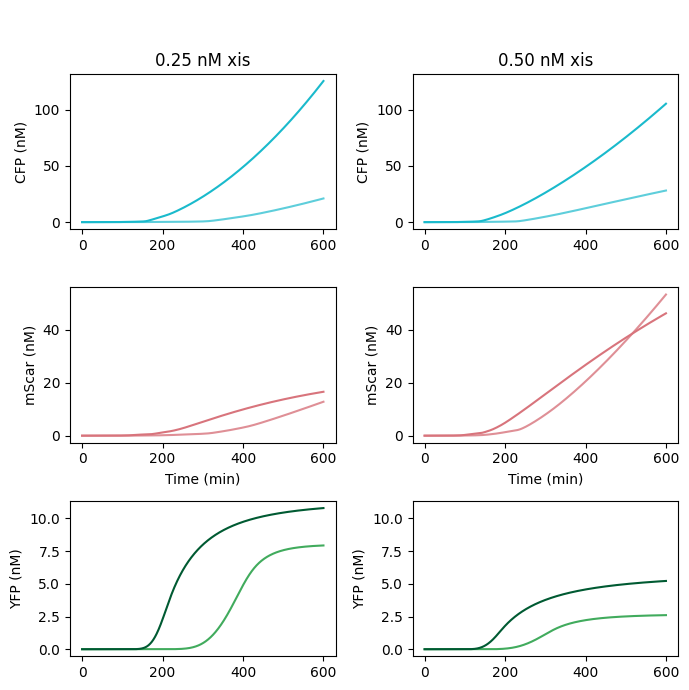

In [45]:
## Plot the results:
colorcfp = ['#5ecedb','#1abacc']
colormscar = ['#df8f96','#d8747c']
coloryfp = ['#41ab5d','#005a32']
figsize = (7,7)
fig = plt.figure(figsize = figsize)
index = 1
for exc_ind in range(len(exc_levels)):
    if index == 1:
        axc = fig.add_subplot(3,len(int_levels),index)
        axm = fig.add_subplot(3,len(exc_levels),index+2)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2)
    else:
        axc = fig.add_subplot(3,len(int_levels),index, sharey = axc)
        axm = fig.add_subplot(3,len(exc_levels),index+2, sharey = axm)
        axy = fig.add_subplot(3,len(exc_levels),index+2*2, sharey = axy)
    count = 0
    for int_ind in range(len(int_levels)):
        axc.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'cfp')],
                 color=colorcfp[count])
        axm.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'mScar')],
                 color=colormscar[count])
        axy.plot(timepoints, simdata[(int_levels[int_ind], exc_levels[exc_ind],'yfp')],
                 color=coloryfp[count])
        count += 1
        axc.set_title('\n\n%1.2f nM xis' % (exc_levels[exc_ind]))
        axm.set_xlabel('Time (min)')
        axc.set_ylabel('CFP (nM)')
        axm.set_ylabel('mScar (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1

fig.tight_layout()